<a href="https://colab.research.google.com/github/Alf-caput/P4_AlgoritmoGenetico/blob/dev1/P4_AlgGen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PRÁCTICA 4: Algoritmo genético

### Ana Robledano, Miguel Egido, Alfredo Robledano.

1.- Encontrar los máximos de la función "picos"

$$z = f(x,y) = 3(1-x)^2e^{-(x^2)-(y+1)^2}-10(x/5-x^3-y^5)e^{-x^2-y^2}-1/3e^{-(x+1)^2-y^2}$$

En el dominio $$\{x,y\} \in [-100,100]$$


Instalamos la librería deap

In [200]:
!pip install deap


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Inicialización de hiperparámetros

In [201]:
import random
from deap import base, creator, tools

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

random.seed(42)           # Para obtener los mismos resultados siempre

VALID_RANGE = (-100, 100) # Dominio
INDIVIDUAL_SIZE = 2

Definimos la función del enunciado:

In [202]:
import math
from functools import partial

F = lambda x, y: 3*(1-x)**2*math.exp(-(x**2)-(y+1)**2)-10*(x/5-x**3-y**5)*math.exp(-x**2-y**2)-1/3*math.exp(-(x+1)**2-y**2)

def evaluate_fit(individual, target_function, gene_range):
    for gene in individual:
        if not (gene_range[0] <= gene <= gene_range[1]):
            return -1,
    return target_function(*individual),

Y graficamos la función para ver que aspecto tiene.

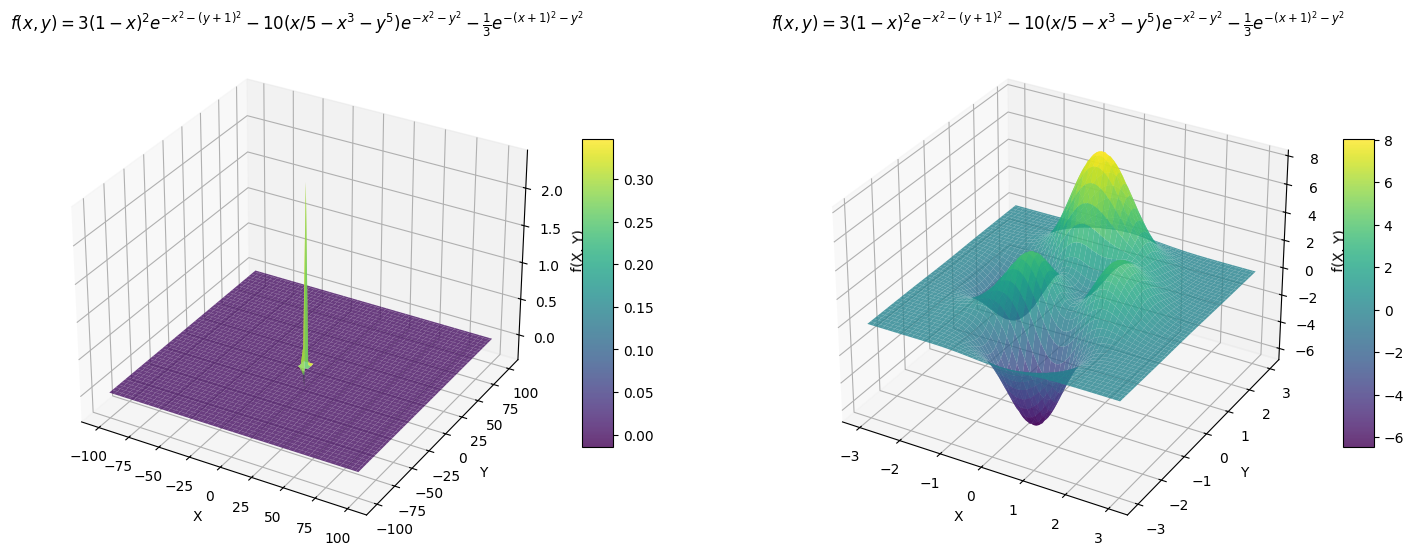

In [203]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Función
F = lambda x, y: 3*(1-x)**2*np.exp(-x**2-(y+1)**2)-10*(x/5-x**3-y**5)*np.exp(-x**2-y**2)-1/3*np.exp(-(x+1)**2-y**2)

# Rango gráfica 1
x1 = np.linspace(-100, 100, 100)
y1 = np.linspace(-100, 100, 100)

X1, Y1 = np.meshgrid(x1, y1)
Z1 = f(X1, Y1)

#Rango gráfica 2
x2 = np.linspace(-3, 3, 100)
y2 = np.linspace(-3, 3, 100)

X2, Y2 = np.meshgrid(x2, y2)
Z2 = f(X2, Y2)

fig = plt.figure(figsize=(18, 8))

# Gráfica 1
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(X1, Y1, Z1, cmap='viridis', edgecolor='none', alpha=0.8)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('f(X, Y)')
title_text1 = r'$f(x, y) = 3(1-x)^2e^{-x^2-(y+1)^2} - 10(x/5 - x^3 - y^5)e^{-x^2-y^2} - \frac{1}{3}e^{-(x+1)^2-y^2}$'
ax1.set_title(title_text1, fontsize=12)
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)

#Gráfica 2
ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(X2, Y2, f(X2, Y2), cmap='viridis', edgecolor='none', alpha=0.8)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('f(X, Y)')
title_text2 = r'$f(x, y) = 3(1-x)^2e^{-x^2-(y+1)^2} - 10(x/5 - x^3 - y^5)e^{-x^2-y^2} - \frac{1}{3}e^{-(x+1)^2-y^2}$'
ax2.set_title(title_text2, fontsize=12)
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)

plt.show()

Observamos que la función alcanza un máximo absoluto en para lo valores centrales de x e y. Por ello, vamos hemos restringido los límites de la gráfica y tomaremos un sub dominio, que usaremos para producir individuos aleatorios, que inicien en valores centrales de x e y. De esta manera, ahorramos en iteraciones, inicializando la población para valores próximos al máximo.

Además vemos en la segunda gráfica, que hay 1 mínimo absoluto y 3 máximos, es decir, 2 de ellos son máximos relativos y el restante es absoluto (al que queremos llegar).

In [204]:
VALID_RANGE_INITIAL = (-3, 3)

Elegimos un tamaño de población de 32 para obtener un procedimiento similar a ejemplos anteriores además cumple con el requisito de que es **divisibles entre 4**

In [205]:
POPULATION_SIZE = 32

toolbox = base.Toolbox()

En el Toolbox registraremos funciones necesarias para ejecutar el AG, a través del método `register` de la clase base.Toolbox que tiene los atributos:

- `alias`: El nombre con el que registramos la función en el Toolbox
- `function`: La función que estamos registrando
- `argument`: Los argumentos que se pasan a la función

Registramos la función `attr_uniform` (Que será un método de la clase `toolbox`) que permite **crear individuos aleatorios** desarrollando una función (usaremos `random.uniform`) que nos permita generar un valor aleatorio para cada variable independiente (cada gen del comosoma), esto es, cada una de las posiciones de la lista con valores sujetos a las restricciones de nuestro problema (-100, 100)

In [206]:
# Generación de genes
toolbox.register("attr_uniform", random.uniform, *VALID_RANGE_INITIAL)

In [207]:
# Probamos y vemos que generamos un número leatorio entre -3 y 3 distinto cada vez
toolbox.attr_uniform()

0.8365607907473027

Creamos el individuo completo llamando a la función que genera cada uno de los individuos tantas veces como variables independientes tengamos. Eso lo hacemos registrando la función individual que, a su vez, llama a la función tools.

In [208]:
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_uniform, INDIVIDUAL_SIZE)

In [209]:
# Ejemplo de la generación de un individuo aleatorio
individuo = toolbox.individual()
individuo

[-2.8499354686639986, -1.3498240897852845]

Ahora, registramos la función de fitness:

In [210]:
toolbox.register("evaluate", partial(evaluate_fit, target_function=F, gene_range=VALID_RANGE))
# Ejemplo de uso 1
F(individuo[0], individuo[1])

-0.0030682496832484837

La función fitness devuelve una tupla ya que la solución es generalista para un problema genérico multiobjetivo, aunque en nuestro caso solo sea uno.

In [211]:
# Recordar que individuo es una lista que tiene un atributo fitness
# donde se almacena la calidad del mismo, que al principio será
# vacío, porque aun no ha sido evaluado
individuo.fitness.values

()

El procedimiento para crear una población es análogo a la creación de un individuo:

In [212]:
# Generación de población
toolbox.register("population", tools.initRepeat, list, toolbox.individual, POPULATION_SIZE)

Como se puede ver, se registra la función `population` que utiliza `initRepeat` para llamar 32 veces a la función `Individual` (una vez por cad individuo que formará la población inicial). El resultado se guarda en una `list` que contiene la población inicial generada. Se recomienda elegir números **divisibles entre 4**, ya que algunas operaciones genéticas del módulo `deap` pueden dar problemas si no se cumple este requisito

In [213]:
# Ejemplo de creación de una población. Se ve que es
# una lista de 32 listas (una por cada individuo)
poblacion = toolbox.population()
print(poblacion)

[[-1.6607355711070635, 1.418827284984074], [1.0601969245374683, 2.3530774062290725], [-2.478367004223503, -0.46846908188837766], [-2.8212166833715777, -1.6881721511783798], [0.03213172862017455, -2.8407841818968183], [-1.806974095880109, 0.8993066266771392], [0.26964888361930006, -1.6773562677558198], [0.5355941032554523, 1.8565827400669601], [-2.961007441931634, 1.8349155109968471], [1.1888363699293611, -0.9584969008920488], [-2.0671230011293105, 2.743278433240687], [-0.9804327293242396, -2.4435249397191123], [-2.419701738999216, 2.084966198084759], [0.6223561882013464, 1.8427696396462814], [1.3783907201629075, 0.21736854872820466], [2.838694583876224, -0.7287937367498794], [0.3122437876393622, 1.9764279855179687], [0.7111185141854763, 2.170241401864663], [0.46411287154057224, 1.2274310172895406], [-2.7250536980660267, -1.6326103460907189], [-1.263672218387357, -2.521248138458235], [-1.603254681833819, -2.3939914235416255], [-1.3321583813394473, 0.8141066655864009], [-0.81100692617949

In [214]:
poblacion[0].fitness.values

()

La función fitness devuelve una tupla ya que la solución es generalista para un problema genérico multiobjetivo, aunque en nuestro caso solo sea uno.

## Incorporar los operadores genéticos

Preparamos los valores iniciales y constantes que usaremos para el algoritmo.

* **Selección**:`selection`. Procedimiento por el cual se seleccionan los individuos que participarán en las operaciones de cruce y mutación. Procedimiento siempre **elitista**: Un individuo tendrá mayor probabilidad de dejar descendencia si su `fitness` es más adecuado al problema de optimización (razonamiento en línea con la teoría evolutiva de Darwin) -> Las probabilidades de dejar descendencia en las futuras generaciones crecen cuando crece la adaptación del individuo al medio. **OJO CON LOS SUPERINDIVIDUOS**
* **Cruce**: `mate`. Operación probabilística que permite que dos individuos seleccionados **crucen** o **intercambien** su información genética para crear dos nuevos individuos
* **Mutación**: `mutation`. Operación probabilística que permite que un individuo seleccionado **modifique** su información genética para crear un nuevo individuo.

Ni para la probabilidad de cruce ni para la de mutación existen valores óptimos que sirva para todos los problemas. Tendrán que ajustarse a cada problema.

Destacar que tanto el **cruce** como la **mutación** son el **motor para explorar y explotar zonas del espacio de búsqueda**.

In [215]:
MU = 0 # mean
SIGMA = 5 # standard deviation
INDPB = 0.1 # independent probability for each atribute to be mutated
TOURNAMENT_SIZE = 3

## Cruce

Utilizamos ``cxOnePoint(ind1, ind2)`` o cruce en un punto que ya conocéis `cxOnePoint`, selecciona de manera aleatoria un punto (una posición) dentro de los individuos `ind1`, `ind2` para hacer un intercambio entre la información genética de dos individuos (padres) seleccionados


In [216]:
# CRUCE
toolbox.register("mate", tools.cxOnePoint)

En este caso, al ser la longitud de los individuos 2, solo existe un posible punto de cruce (el cruce será simplemente intercambiar los valores de x e y)

## Mutación

Utilizamos el operador `mutGaussian` (mutación Gaussiana) con una media de 0 y una deviación típica de 5 (son solo de ejemplo y no garantizan ser los más adecuados. Posiblemente habrá que probar valores distintos)

In [217]:
# MUTACIÓN
toolbox.register("mutate", tools.mutGaussian, mu=MU, sigma=SIGMA, indpb=INDPB)

`MutGaussian` consiste en mutar, con una probabilidad `indpb` cada uno de los genes del individuo `individual`, sumando a cada uno de ellos una cierta cantidad aleatoria. Esta cantidad se genera según una función de probabilidad Gaussiana (o normal), de media `mu` y desviación típica `sigma`.

En el caso de la mutación, se deben definir dos probabilidades:

- La probabilidad de mutar un individuo (lo veremos más adelante)
- La probabilidad de mutar cada uno de los genes del individuo (`indpb`)

Este último valor, en general, debe ser bajo para que la mutación no modifique en exceso al individuo. Valores muy altos de esta probabilidad pueden hacer que el algoritmo no converja correctamente, o que no se intensifiquen ciertas zonas del espacio de búsqueda.

## Selección

In [218]:
# SELECCIÓN
toolbox.register("select", tools.selTournament, tournsize=TOURNAMENT_SIZE)

Hemos usado el operador `selTournament(individuals, k, tournsize)` que nos permite realizar una selección mediante torneo. En este caso fijamos un tamaño igual a 3. Se ha demostrado que este tamaño funciona relativamente bien para la mayoría de los casos Lones 2011

El algoritmo realiza tantos torneos como individuos tiene la población. Aunque 3 es válido para la mayoría de los casos, cuando la población crece mucho, se deben utilizar tamaños más altos para hacer más rápida la convergencia del algoritmo. La selección con torneo es muy elitista y hace que el algoritmo converja más rapidamente que, por ejemplo, con el algoritmo de la ruleta.

# Configuración del algoritmo genético

In [219]:
from deap import algorithms
import numpy as np

CXPB = 0.5  # probability of mating 2 individuals
MUTPB = 0.2 # probabilty of mutating an individual
NGEN = 20   # number of generations

#Generamos la Población Inicial
pop = toolbox.population()
print(type(pop))

# Definimos el objeto hof que almacenará el mejor individuo
# encontrado a lo largo de las generaciones del Algoritmo G.
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)

# Ahora registramos en el objeto stats las funciones estadísticas a utilizar junto con su alias:
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

<class 'list'>


El objeto `stats` tiene un método `compile` **Método Compile**, que recibe como entrada la población que permite generar las estadísticas. A este método se le llama internamente en cada generación del algoritmo.

In [220]:
logbook = tools.Logbook()
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN, stats=stats, halloffame=hof, verbose=True)

gen	nevals	avg      	std    	min     	max    
0  	32    	-0.022886	2.28267	-5.78735	7.52581
1  	15    	1.96212  	2.46999	-4.17425	7.52581
2  	18    	3.73903  	2.58809	0.320446	7.721  
3  	19    	6.21131  	2.06854	-1.75478	7.721  
4  	13    	7.09283  	1.47392	1.38843e-13	7.721  
5  	24    	7.51149  	0.649678	3.99139    	7.721  
6  	23    	7.45226  	1.24501 	0.64154    	7.721  
7  	20    	6.99715  	2.25052 	-2.86862e-19	7.721  
8  	19    	7.32278  	2.21719 	-5.02202    	7.721  
9  	12    	7.721    	0       	7.721       	7.721  
10 	17    	7.721    	0       	7.721       	7.721  
11 	23    	7.47972  	1.3434  	1.9617e-06  	7.721  
12 	18    	7.721    	0       	7.721       	7.721  
13 	22    	6.99735  	2.24991 	-1.34917e-11	7.721  
14 	20    	7.43976  	1.3546  	6.26148e-20 	7.721  
15 	22    	7.42505  	1.64776 	-1.74929    	7.721  
16 	17    	7.25783  	1.79551 	-2.45966e-08	7.721  
17 	18    	7.47972  	1.3434  	3.44096e-22 	7.721  
18 	26    	7.53225  	1.05091 	1.68101     	7.721  
19 	16   

In [221]:
print(pop)

[[0.17468607059482189, 1.6717588717833491], [0.17468607059482189, 1.6717588717833491], [0.17468607059482189, 1.6717588717833491], [0.17468607059482189, 1.6717588717833491], [0.17468607059482189, 1.6717588717833491], [0.17468607059482189, 1.6717588717833491], [5.197369918778458, 1.6717588717833491], [0.17468607059482189, 1.6717588717833491], [0.17468607059482189, 1.6717588717833491], [0.17468607059482189, 1.6717588717833491], [0.17468607059482189, 1.6717588717833491], [0.17468607059482189, 1.6717588717833491], [0.17468607059482189, 1.6717588717833491], [0.17468607059482189, 1.6717588717833491], [0.17468607059482189, 1.6717588717833491], [0.17468607059482189, 1.6717588717833491], [0.17468607059482189, 1.6717588717833491], [0.17468607059482189, 1.6717588717833491], [0.17468607059482189, 1.6717588717833491], [0.17468607059482189, 1.6717588717833491], [0.17468607059482189, 1.6717588717833491], [0.17468607059482189, 1.6717588717833491], [0.17468607059482189, 1.6717588717833491], [0.174686070

In [222]:
print(logbook)

gen	nevals	avg      	std     	min         	max    
0  	32    	-0.022886	2.28267 	-5.78735    	7.52581
1  	15    	1.96212  	2.46999 	-4.17425    	7.52581
2  	18    	3.73903  	2.58809 	0.320446    	7.721  
3  	19    	6.21131  	2.06854 	-1.75478    	7.721  
4  	13    	7.09283  	1.47392 	1.38843e-13 	7.721  
5  	24    	7.51149  	0.649678	3.99139     	7.721  
6  	23    	7.45226  	1.24501 	0.64154     	7.721  
7  	20    	6.99715  	2.25052 	-2.86862e-19	7.721  
8  	19    	7.32278  	2.21719 	-5.02202    	7.721  
9  	12    	7.721    	0       	7.721       	7.721  
10 	17    	7.721    	0       	7.721       	7.721  
11 	23    	7.47972  	1.3434  	1.9617e-06  	7.721  
12 	18    	7.721    	0       	7.721       	7.721  
13 	22    	6.99735  	2.24991 	-1.34917e-11	7.721  
14 	20    	7.43976  	1.3546  	6.26148e-20 	7.721  
15 	22    	7.42505  	1.64776 	-1.74929    	7.721  
16 	17    	7.25783  	1.79551 	-2.45966e-08	7.721  
17 	18    	7.47972  	1.3434  	3.44096e-22 	7.721  
18 	26    	7.53225  	1.05091 	1

# Resultados del Algoritmo

In [223]:
print("Mejor fitness: %f" %hof[0].fitness.values)
print("Mejor individuo %s" %hof[0])

Mejor fitness: 7.720998
Mejor individuo [0.17468607059482189, 1.6717588717833491]


Nos da unos valores acordes a la gráfica que hicimos anteriormente. El mejor fitness es en z = 7.7, que coincide con la gráfica de la función, donde alredor de 8 se alcanza el máximo absoluto.

In [224]:
print(logbook)

gen	nevals	avg      	std     	min         	max    
0  	32    	-0.022886	2.28267 	-5.78735    	7.52581
1  	15    	1.96212  	2.46999 	-4.17425    	7.52581
2  	18    	3.73903  	2.58809 	0.320446    	7.721  
3  	19    	6.21131  	2.06854 	-1.75478    	7.721  
4  	13    	7.09283  	1.47392 	1.38843e-13 	7.721  
5  	24    	7.51149  	0.649678	3.99139     	7.721  
6  	23    	7.45226  	1.24501 	0.64154     	7.721  
7  	20    	6.99715  	2.25052 	-2.86862e-19	7.721  
8  	19    	7.32278  	2.21719 	-5.02202    	7.721  
9  	12    	7.721    	0       	7.721       	7.721  
10 	17    	7.721    	0       	7.721       	7.721  
11 	23    	7.47972  	1.3434  	1.9617e-06  	7.721  
12 	18    	7.721    	0       	7.721       	7.721  
13 	22    	6.99735  	2.24991 	-1.34917e-11	7.721  
14 	20    	7.43976  	1.3546  	6.26148e-20 	7.721  
15 	22    	7.42505  	1.64776 	-1.74929    	7.721  
16 	17    	7.25783  	1.79551 	-2.45966e-08	7.721  
17 	18    	7.47972  	1.3434  	3.44096e-22 	7.721  
18 	26    	7.53225  	1.05091 	1

# Convergencia del algoritmo

A partir del objeto `Logbook` [Objeto Logbook](https://deap.readthedocs.io/en/master/api/tools.html#logbook) que contiene todos los datos de evolución del algoritmo, desarrollamos la función `plot_evolution` para analizar la convergencia representando la evolución del Algoritmo Genético:

In [225]:
def plot_evolucion(log):
    """
    Representa la evolución del mejor individuo en cada generación
    """
    gen = log.select("gen")
    fit_mins = log.select("min")
    fit_maxs = log.select("max")
    fit_ave = log.select("avg")

    fig, ax1 = plt.subplots()
    ax1.plot(gen, fit_mins, "b")
    ax1.plot(gen, fit_maxs, "r")
    ax1.plot(gen, fit_ave, "--k")
    # ax1.fill_between(gen, fit_mins, fit_maxs, where=fit_maxs >= fit_mins, facecolor='g', alpha = 0.2)
    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Fitness")
    #ax1.set_ylim([-10, 20])
    ax1.legend(["Min", "Max", "Avg"], loc="lower center")
    plt.grid(True)
    plt.savefig("Convergencia.eps", dpi = 300)

Pintamos la Gráfica:

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


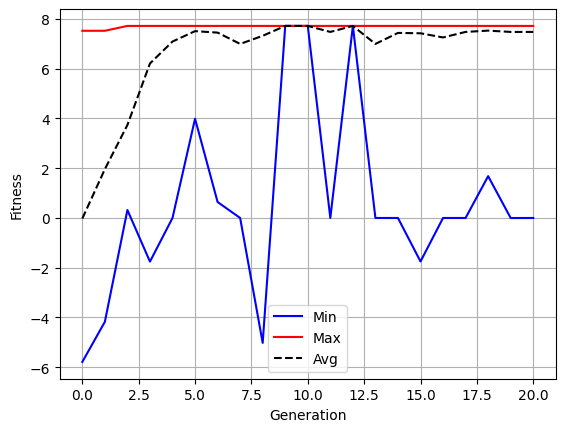

In [226]:
plot_evolucion(logbook)

Vemos que el máximo se alcanza rápidamente y los mínimos varían, esto se debe a que hay exploraciones, donde los individuos se alejan del máximo, para explorar otras zonas y salir de un posible máximo local.

Por otra parte, en donde el mínimo aumenta, se da un proceso de explotación para seguir maximizando.

La mezcla de selección, cruce y mutación generan exploración y explotación.

El algoritmo converge ya que la media y el máximo están practicamente superpuestas. No obstante, se consigue el máximo 7.7 en generaciones anteriores, es decir, podríamos evitar iteraciones, y terminar en la generación 2, y obtendríamos el mismo mejor fitness.

In [227]:
# Reducción del número de generaciones
logbook = tools.Logbook()
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=2, stats=stats, halloffame=hof, verbose=True)
print("Mejor fitness: %f" %hof[0].fitness.values)
print("Mejor individuo %s" %hof[0])

gen	nevals	avg    	std   	min        	max  
0  	0     	7.47972	1.3434	1.72987e-10	7.721
1  	18    	7.721  	0     	7.721      	7.721
2  	18    	7.47972	1.3434	3.42134e-07	7.721
Mejor fitness: 7.720998
Mejor individuo [0.17468607059482189, 1.6717588717833491]


Reduciendo `ngen`, número de generaciones a 2, conseguimos el mismo máximo. De esta manera evitamos cálculos innecesarios.

# Posibles mejoras

Probamos cambiando el cruce a por dos puntos en vez de 1.

In [228]:
# Cruce por 2 puntos
toolbox.register("mate", tools.cxTwoPoint)

# Generamos una nueva población
pop = toolbox.population()

# Definimos el mejor individuo
hof = tools.HallOfFame(1)

logbook = tools.Logbook()
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN, stats=stats, halloffame=hof, verbose=True)

print("Mejor fitness: %f" %hof[0].fitness.values)
print("Mejor individuo %s" %hof[0])

gen	nevals	avg     	std    	min     	max   
0  	32    	0.243735	1.58991	-5.22755	4.7479
1  	20    	1.39954 	2.16124	-3.21032	4.7479
2  	19    	2.60398 	1.82774	-0.0599757	6.72349
3  	18    	4.18975 	1.77655	1.10599   	6.72349
4  	19    	5.42016 	1.39525	0.000139964	7.39932
5  	19    	6.39442 	0.873382	4.7479     	7.69958
6  	17    	7.05747 	0.347677	6.72349    	7.69958
7  	17    	7.3521  	0.282756	6.72349    	7.69958
8  	18    	7.24693 	1.86383 	-3.08622   	7.69958
9  	16    	7.4402  	1.33827 	7.70039e-14	7.69958
10 	19    	7.21807 	1.86487 	-0.0086653 	7.69958
11 	15    	7.45897 	1.33967 	3.61248e-37	7.69958
12 	19    	7.2424  	1.77345 	-0.0129901 	7.69958
13 	15    	6.72586 	2.57682 	-0.360469  	7.69958
14 	19    	7.46356 	1.31409 	0.147037   	7.69958
15 	21    	7.69958 	0       	7.69958    	7.69958
16 	19    	7.17329 	2.05643 	-1.81029   	7.69958
17 	25    	7.21802 	1.86509 	-0.0108642 	7.69958
18 	12    	7.36003 	1.89054 	-3.16606   	7.69958
19 	22    	6.82957 	2.33052 	-0.0753136 

El mejor fitness ha empeorado un poco, siendo 7.7 el obtenido anteriormente.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


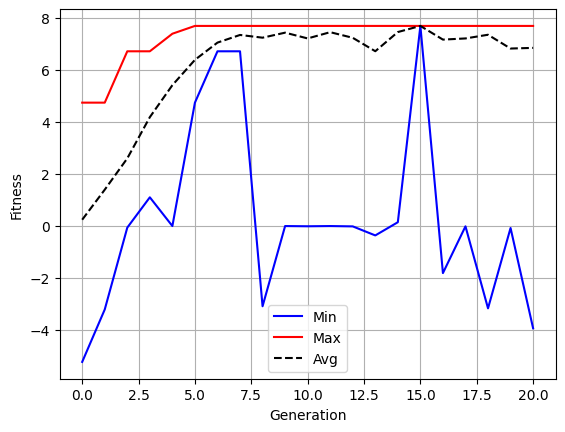

In [229]:
plot_evolucion(logbook)

Como podemos observar el fitness del mejor individuo para este tipo es peor para estos hiperparámetros. No obstante podríamos añadir más generaciones para comprobar si el máximo puede seguir mejorando.

In [230]:
logbook = tools.Logbook()
# Incrementamos el número de generaciones a 30 (ngen=30)
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=30, stats=stats, halloffame=hof, verbose=True)

print("Mejor fitness: %f" %hof[0].fitness.values)
print("Mejor individuo %s" %hof[0])

gen	nevals	avg    	std   	min     	max    
0  	0     	6.85483	2.6871	-3.93329	7.69958
1  	21    	7.69958	0     	7.69958 	7.69958
2  	19    	7.69958	0     	7.69958 	7.69958
3  	26    	7.47   	1.34306	-2.27432e-49	8.05261
4  	15    	7.51397	1.3565 	-0.00511254 	8.05261
5  	13    	7.45014	1.5733 	-1.36662e-54	8.05261
6  	22    	7.71065	1.39694	7.2968e-14  	8.05261
7  	20    	7.54914	1.94995	-0.00600425 	8.05261
8  	19    	8.054  	0.00772	8.05261     	8.09698
9  	18    	7.81689	1.34442	0.331923    	8.09698
10 	16    	7.81899	1.4045 	-9.00669e-08	8.09698
11 	16    	8.08589	0.0192126	8.05261     	8.09698
12 	23    	7.84395	1.40882  	5.03426e-60 	8.09698
13 	16    	7.84395	1.40882  	2.91359e-07 	8.09698
14 	20    	7.59392	1.86091  	6.29784e-16 	8.09698
15 	21    	8.09698	0        	8.09698     	8.09698
16 	20    	7.6881 	1.6306   	1.88116e-17 	8.09698
17 	18    	7.85675	1.33755  	0.409599    	8.09698
18 	19    	7.59112	1.95919  	1.14655e-21 	8.09698
19 	21    	7.84395	1.40882  	-4.85141e-22	8.

Efectivamente, se mejora el fitness a 8, que es mejor que cualquiera de los anteriores.

En conclusión, usar 2 puntos de cruce hace que necesitemos más iteraciones, es decir, el algoritmo converge más lentamente. Pero también proporciona mayor precisión, y no se estanca, en lo que parece ser un máximo local. Podría esto indicarnos que al haber más variabilidad en los individuos hijos, hay más diversidad genética.

Otra nota a tener en cuenta, es que si lo que priorizamos es la eficiencia de computo, podría ser más deseado el usar un único punto de cruce, que llega a un máximo aceptable, en muchas menos generaciones.

# EJERCICIO 2
Dada la [Función de Rastringin](https://en.wikipedia.org/wiki/Rastrigin_function#:~:text=In%20mathematical%20optimization%2C%20the%20Rastrigin,has%20been%20generalized%20by%20Rudolph.), con A = 10 y  $$\{xi\} \in [-5.12,5.12]$$

Implementa dicha función en Python y minimízala para n=10

Compara el funcionamiento del Algoritmo Genético para cruce con un punto con cruce con dos puntos

Definimos la función objetivo del enunciado:
$$f(\mathbf{x}) = 10 \cdot n + \sum_{i=1}^{n} \left[ x_i^2 - 10 \cdot \cos(2 \pi x_i) \right]$$

In [231]:
import numpy as np

F = lambda x, n, A: A * n + np.sum(x**2 - A * np.cos(2 * np.pi * x))
F = partial(F, n=10, A=10)

def evaluate_fit(individual, target_function, gene_range):
    for gene in individual:
        if not (gene_range[0] <= gene <= gene_range[1]):
            return abs(target_function(np.array([*individual]))) * 1.5,
    return target_function(np.array([*individual])),

Si el individuo está fuera del dominio, queremos perjudicarlo para que sea eliminado de la población, por ello, a su fit, le asignamos su valor absoluto y multiplicamos por 1.5

In [232]:
# INICIALIZACIÓN DE HIPERPARÁMETROS
import random
from deap import base, creator, tools

# FitnessMin para minimizar
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

random.seed(42)           # Para obtener los mismos resultados siempre

VALID_RANGE = (-5.12, 5.12) # Dominio
n = 10
INDIVIDUAL_SIZE = n         # Hay n = 10 variables xi con i = 0,1, ...,n

# TAMAÑO DE LA POBLACIÓN
POPULATION_SIZE = 32

toolbox = base.Toolbox()

Como el número de dimensiones es `n = 10`, tenemos 10 variables $\{xi\}$ con $\{i = 1,2,3,4,5,6,7,8,9,10\}$ cada una de ellas pertenece al dominio $ [-5.12,5.12]$.

In [233]:
# Generación de genes
toolbox.register("attr_uniform", random.uniform, *VALID_RANGE)
# Generación de individuos
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_uniform, INDIVIDUAL_SIZE)
# Registramos la función de fitness
toolbox.register("evaluate", partial(evaluate_fit, target_function=F, gene_range=VALID_RANGE))
# Generación de población
toolbox.register("population", tools.initRepeat, list, toolbox.individual, POPULATION_SIZE)


## Incorporar los operadores genéticos

Preparamos los valores iniciales y constantes que usaremos para el algoritmo.
Definiremos la probabilidad de cruce, mutación y método de selección.

In [234]:
MU = 0            # media
SIGMA = 5         # desviación típica
INDPB = 0.1       # Probabilidad independiente de cada atributo de mutar
TOURNAMENT_SIZE = 5

In [235]:
# CRUCE
toolbox.register("mate", tools.cxOnePoint)
# MUTACIÓN
toolbox.register("mutate", tools.mutGaussian, mu=MU, sigma=SIGMA, indpb=INDPB)
# SELECCIÓN
toolbox.register("select", tools.selTournament, tournsize=TOURNAMENT_SIZE)

# Configuración del algoritmo genético

In [236]:
from deap import algorithms
import numpy as np

CXPB = 0.5    # probabilidad de cruzar a dos individuos
MUTPB = 0.2   # probabilidad de mutar a un individuo
NGEN = 80     # número de generaciones

# Generamos la Población Inicial
pop = toolbox.population()
print(type(pop))

# Definimos el objeto hof que almacenará el mejor individuo
# encontrado a lo largo de las generaciones del Algoritmo G.
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)

# Ahora registramos en el objeto stats las funciones estadísticas a utilizar junto con su alias:
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

<class 'list'>


In [237]:
logbook = tools.Logbook()
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN, stats=stats, halloffame=hof, verbose=True)

gen	nevals	avg    	std    	min    	max    
0  	32    	190.911	29.4728	121.772	250.492
1  	13    	191.293	198.228	121.772	1282.76
2  	20    	146.28 	65.4793	101.152	427.294
3  	19    	130.863	41.4267	101.152	309.694
4  	24    	118.635	29.8428	95.5626	270.089
5  	21    	102.4  	7.11164	86.4053	121.772
6  	19    	102.345	31.5911	86.4053	273.16 
7  	14    	92.9521	18.6858	82.9369	194.357
8  	19    	95.3137	33.4372	80.8154	244.909
9  	22    	95.1882	40.4112	68.2426	275.618
10 	21    	90.3489	35.8521	68.2426	227.294
11 	19    	79.104 	20.7025	67.0395	190.264
12 	18    	75.906 	25.0857	56.2686	170.83 
13 	17    	96.721 	85.648 	55.0655	377.049
14 	20    	61.868 	8.09131	55.0655	85.1553
15 	22    	79.7204	72.4148	55.0655	365.072
16 	18    	75.994 	51.2142	55.0655	247.06 
17 	14    	59.5599	21.5701	47.3808	175.534
18 	19    	73.9103	65.4903	47.3808	336.003
19 	20    	89.7794	94.3964	47.3808	488.746
20 	16    	66.9348	45.6611	47.3808	244.521
21 	14    	54.9301	19.0643	47.3808	124.171
22 	19    	

# Resultados del Algoritmo

In [238]:
print("Mejor fitness: %f" %hof[0].fitness.values)
print("Mejor individuo %s" %hof[0])

Mejor fitness: 36.819695
Mejor individuo [-0.8271368669606662, 0.07958693837350284, -0.9954663861073227, -0.06896458914192438, 0.017594683875336692, -3.0473881672342036, 1.76977478367861, 0.9753034650848442, -0.05562891804896619, -0.8618369107327049]


Hemos necesitado bastantes generaciones, 80, que en el ejercicio anterior para alcanzar un mínimo aceptable, 36.8

In [239]:
from deap import algorithms
import numpy as np

CXPB = 0.5 # probability of mating 2 individuals
MUTPB = 0.2 # probabilty of mutating an individual
NGEN = 20 # number of generations

pop = toolbox.population()
print(type(pop))

hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)

stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

logbook = tools.Logbook()
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN, stats=stats, halloffame=hof, verbose=True)

<class 'list'>
gen	nevals	avg    	std    	min    	max    
0  	32    	188.858	37.3072	127.633	304.164
1  	16    	160.584	44.1204	119.399	297.429
2  	17    	149.07 	67.3403	99.2748	463.707
3  	25    	142.563	76.98  	88.4791	511.12 
4  	17    	117.256	32.0581	77.6922	227.62 
5  	17    	97.127 	15.0831	77.6922	169.091
6  	24    	99.5674	39.3948	77.6922	227.89 
7  	16    	79.1591	3.43829	77.6922	88.4791
8  	18    	81.7458	15.3489	77.6922	156.099
9  	20    	78.6049	4.15875	74.2883	98.2874
10 	21    	95.574 	60.3704	74.2883	375.707
11 	17    	85.8798	36.8859	74.2883	281.854
12 	22    	91.4477	48.7256	73.0744	319.256
13 	21    	75.4973	6.16871	71.6043	108.752
14 	16    	89.53  	48.677 	71.6043	281.726
15 	24    	82.2653	31.047 	71.6043	233.333
16 	23    	80.3032	30.1499	71.6043	202.245
17 	26    	79.9932	32.1065	71.6043	214.845
18 	21    	102.079	75.9531	71.6043	448.215
19 	16    	80.0381	38.8225	71.6043	294.06 
20 	19    	85.307 	43.3351	71.6043	264.412


Obtenemos el mínimo para los 10 valores de x listados anteriormente.

# Convergencia del algoritmo

Pintamos la Gráfica:

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


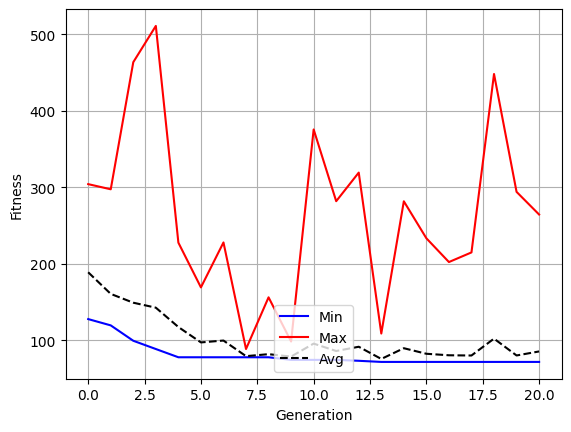

In [240]:
plot_evolucion(logbook)

Vemos como el mínimo mejora lentamente a mayor número de generaciones. El individuo peor adaptado de cada generación, da los valores max, que oscilan bastante, ya que hemos restringido a que los individuos fuera del dominio, tengan fitness altos (es decir, también estén mal adaptados).

# Posibles mejoras

Probamos cambiando el cruce a por dos puntos

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


gen	nevals	avg    	std    	min    	max    
0  	32    	178.774	30.3744	103.547	235.802
1  	20    	147.284	35.5932	103.547	293.952
2  	14    	114.955	14.0402	103.547	147.337
3  	13    	107.477	17.9884	103.547	204.778
4  	16    	119.665	66.4675	103.547	455.597
5  	14    	108.341	25.3511	94.559 	247.416
6  	18    	110.147	36.1272	82.5663	276.473
7  	22    	108.653	34.1944	78.5745	219.445
8  	17    	99.5914	66.1428	78.5745	465.355
9  	18    	92.6039	36.4649	77.5229	219.155
10 	20    	81.8614	13.8225	77.5229	156.487
11 	16    	89.6279	36.8886	77.5229	221.385
12 	16    	89.9575	40.4963	77.5229	268.709
13 	16    	83.7477	24.1558	77.5229	183.154
14 	19    	115.339	80.9821	77.5229	403.84 
15 	17    	77.5229	0      	77.5229	77.5229
16 	20    	101.99 	84.6535	77.5229	527.931
17 	19    	91.6814	58.9504	77.5229	402.774
18 	15    	88.8692	46.6018	77.5229	335.088
19 	21    	82.5043	26.4377	77.5229	229.529
20 	22    	107.598	68.0859	77.5229	344.815
Mejor fitness: 77.522912
Mejor individuo [1.0570778241

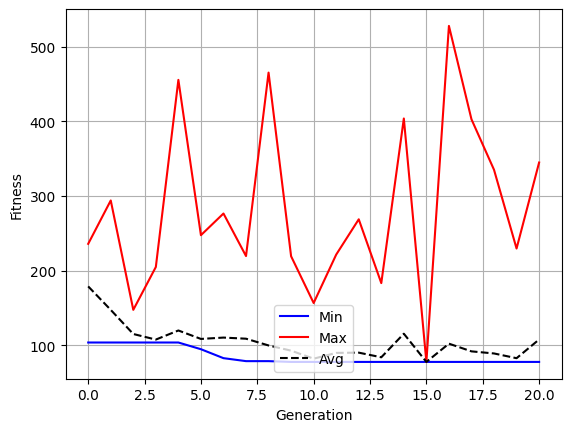

In [241]:
# Cruce por 2 puntos
toolbox.register("mate", tools.cxTwoPoint)

# Generamos una nueva población
pop = toolbox.population()

# Definimos el mejor individuo
hof = tools.HallOfFame(1)

logbook = tools.Logbook()
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN, stats=stats, halloffame=hof, verbose=True)

print("Mejor fitness: %f" %hof[0].fitness.values)
print("Mejor individuo %s" %hof[0])
plot_evolucion(logbook)

Para 2 puntos de cruce, tenemos que el mínimo empeora a 77.5, sigue habiendo zonas de la gráfica de exploración (llevadas a cabo por individuos que se alejan del mínimo para salir de un posible mínimo local) y de explotación en donde se mejora el fitness.